In [1]:
#!/usr/bin/env python
import sys,os
#print sys.path
sys.path=["/home/Zhi/QA-sim","/home/Zhi/april/py"]+sys.path
print(sys.path)
from Parameter import Parameter
from BaseLikelihood import BaseLikelihood
import MCMCAnalyzer
import numpy as np
import quasim as qua
import math
import matplotlib.pyplot as plt
import corner
from uncertainties import ufloat
from uncertainties.umath import sqrt

['/home/Zhi/QA-sim', '/home/Zhi/april/py', '/home/Zhi/QA-sim/notebook', '/usr/lib64/python39.zip', '/usr/lib64/python3.9', '/usr/lib64/python3.9/lib-dynload', '', '/home/Zhi/.local/lib/python3.9/site-packages', '/usr/lib64/python3.9/site-packages', '/usr/lib/python3.9/site-packages', '/usr/lib/python3.9/site-packages/IPython/extensions', '/home/Zhi/.ipython']


In [3]:
# Create Input data
# Create star pair position placed in the E-W direction. Dec=0

QT = qua.QuaTel(ph=0.3)
BSC = qua.BSC_process("/home/Zhi/QA-sim/bsc5.dat")

#pos = np.array([[0,1.2,0.0,450.0],[0,1.202,0.0,90.0]])
pos = BSC.BSC_filter(3)

lam = 1*10**(-6)

# Baseline vector in [B_EW,B_NS,L=latitude]
B = [200.,0.,np.pi/4.]

# Use some sample star, here I use sample pos[0] as a sample star
print(pos[3])
T = [-10000,10000]      #[-10000,+10000]
source = pos[3]-np.array([[0.,pos[3][1,1],0.,0.],[0.,pos[3][1,1],0.,0.]])
print(source)

num, t, baseline, theo_phase, d_source = QT.get_num_photon(source,B,lam,T,'pos')
num = num[0] 
theo_phase = theo_phase[0]

#create simulated data based on theoretical rates generated above
task4 = qua.sim_data(num*5,t,theo_phase,'pos')   

print('theo_d',d_source[0,int(d_source[0,:,0].size/2),:])
#print('theo_d',d_source[0,0,:])
pos = BSC.BSC_filter(3)


[[5.05500000e+03 3.50785000e+00 9.58563914e-01 9.57417549e+01]
 [5.05400000e+03 3.50778455e+00 9.58626940e-01 4.49884866e+02]]
[[5.05500000e+03 6.54498469e-05 9.58563914e-01 9.57417549e+01]
 [5.05400000e+03 0.00000000e+00 9.58626940e-01 4.49884866e+02]]
theo_d [ 5.15781341e-05  3.76137537e-05 -3.62190263e-05]


In [1]:
'''Paper configuration'''
QT = qua.QuaTel(ph=0.3)
BSC = qua.BSC_process("/home/Zhi/QA-sim/bsc5.dat")

lam = 1*10**(-6)

# Baseline vector in [B_EW,B_NS,L=latitude]
B = [200.,0.,0.]

#pos = np.array([[0,1.2,0.0,450.0],[0,1.202,0.0,90.0]])
pos = BSC.BSC_filter(3)

# Use some sample star, here I use sample pos[0] as a sample star
print(pos[3])
T = [-10000,10000]      #[-10000,+10000]
#source = np.array([[0,0.78539816,0.,38.],[0,0.78539816+0.0,0.,300.]])
source = pos[3] - np.array([[0.,0.,pos[3][0,2],0.],[0.,0.,pos[3][1,2],0.]])
print(source)
num, t, baseline, theo_phase, d_source = QT.get_num_photon(source,B,lam,T,'pos')
num = num[0] 
theo_phase = theo_phase[0]
#create simulated data based on theoretical rates generated above
task4 = qua.sim_data(num*10,t,theo_phase,'pos')   

print('theo_d',d_source[0,int(d_source[0,:,0].size/2),:])
#print('theo_d',d_source[0,0,:])
pos = BSC.BSC_filter(3)

NameError: name 'qua' is not defined

In [45]:
task4.N

13747

Text(0, 0.5, 'Rates[Hz]')

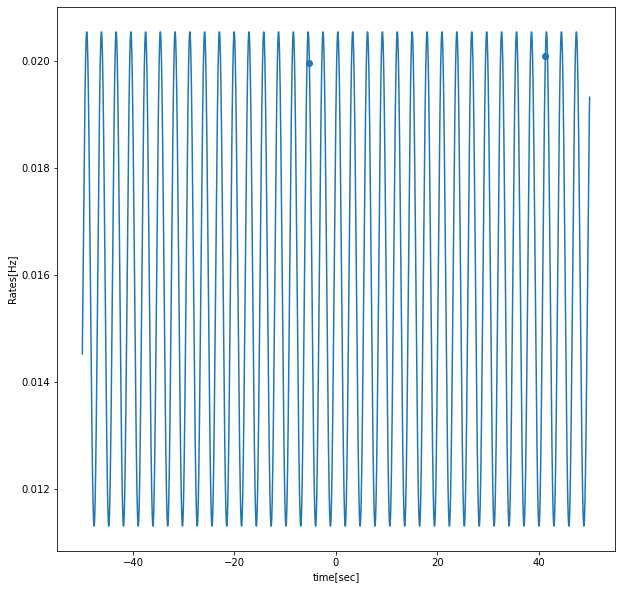

In [6]:
plt.figure(figsize=(10,10))
#plt.xlim([-5000,-4900])
plt.plot(t,num,label='Theo rate curve')
plt.scatter(task4.timestamp,task4.sim_num)
plt.xlabel('time[sec]');plt.ylabel('Rates[Hz]')
#plt.legend()

In [4]:
# Find theoretical separation of two sources in d_ew and d_ns of the tangent plane centered at dec_mid and ra_mid
def theo_ds(pos_s,theo):
    pos = np.delete(pos_s,0,axis=1)
    x = np.cos(pos[:,1])*np.cos(pos[:,0])
    y = np.cos(pos[:,1])*np.sin(pos[:,0])
    z = np.sin(pos[:,1])
               
    s = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1]])/2)
    phi = math.atan2((y[0]+y[1]),(x[0]+x[1]))
     
    # Use theo d_source in cart to convert to d_ns and d_ew
    d_ns_theo = theo[2]/s     #
    d_ew_theo = (theo[1]+np.sin(phi)*((z[0]+z[1])/2)*d_ns_theo)/np.cos(phi)
 
    #d_ns_theo = pos[0,1]-pos[1,1]
    #d_ew_theo = (pos[0,0]-pos[1,0])*s
    
    return d_ew_theo, d_ns_theo

#d_ew_theo, d_ns_theo = theo_ds(pos[3],d_source[0,int(d_source[0,:,0].size/2)+1,:])
d_ew_theo, d_ns_theo = theo_ds(source,d_source[0,int(d_source[0,:,0].size/2)+1,:])
theo_par = [task4.V, d_ew_theo, d_ns_theo, QT.ph]
print(theo_par)

[0.28936210885736124, 3.7612065286649044e-05, -6.302577859893118e-05, 0.3]


In [5]:
# create sim_data class for mcmc

class sim_data(BaseLikelihood):
    
    def __init__(self, seed, pos_t, pos_s, t, lam,theo_d):  # seed = [V_init,d_ra_init, d_dec_init]
        BaseLikelihood.__init__(self,"sim_data")  
        
        # free par
        self.seed = seed
        self.V = seed[0]
        self.d_ew = seed[1]
        self.d_ns = seed[2]
        self.offset = seed[3]
        
        # fixed values
        self.t = t             # timestamp for the sim data
        
        self.baseline = np.array(pos_t)
        
        pos_s = np.delete(pos_s, 0, axis=1)  # delete star # part.
        self.pos_s = pos_s     # position of sources to determine midpoint
        
        self.lam = lam         # lambda for observation
        self.Omega_E = 7.292e-5
        self.theo_d = theo_d
    def freeParameters(self):
        return [
                Parameter("V", self.seed[0], err=0.05,),    #0.05
                Parameter("d_ew",self.seed[1], err=5e-10),   #1e-7
                Parameter("d_ns",self.seed[2], err=5e-10),
                Parameter("offset",self.seed[3], err=np.pi/8,)   
                ]
    
    def updateParams(self,params):    #params is also a class, updates param value.
        for p in params:
            if p.name=="V":
                self.V=p.value
            if p.name=="d_ew":
                self.d_ew=p.value
            if p.name=="d_ns":
                self.d_ns=p.value
            if p.name=="offset":
                self.offset=p.value
                
    def pos_carte(self, ti):
        N = ti.size
        x = np.cos(self.pos_s[:,1])*np.cos(self.pos_s[:,0])
        y = np.cos(self.pos_s[:,1])*np.sin(self.pos_s[:,0])
        z = np.sin(self.pos_s[:,1])
               
        s = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1]])/2)
    
        ra_mid = math.atan2(y[0]+y[1],x[0]+x[1])
        dec_mid = np.arcsin((z[0]+z[1])/2)
                
        fin_z = np.tile(np.cos(dec_mid)*self.d_ns,(N))
        fin_x =(-np.cos(ra_mid)*np.sin(dec_mid)*self.d_ns - np.sin(ra_mid)*self.d_ew)
        fin_y =(-np.sin(ra_mid)*np.sin(dec_mid)*self.d_ns + np.cos(ra_mid)*self.d_ew)
        
        init_phi = math.atan2(fin_y,fin_x)
        fin_xt = np.sqrt(fin_x**2 + fin_y **2)*np.cos(-self.Omega_E*ti + init_phi)
        fin_yt = np.sqrt(fin_x**2 + fin_y **2)*np.sin(-self.Omega_E*ti + init_phi)
        
        
        #fin_z = np.tile(self.theo_d[2],(N))
        #init_phi = math.atan2(self.theo_d[1],self.theo_d[0])
        #fin_xt = np.sqrt(self.theo_d[0]**2 + self.theo_d[1]**2)*np.cos(-self.Omega_E*ti + init_phi)
        #fin_yt = np.sqrt(self.theo_d[0]**2 + self.theo_d[1]**2)*np.sin(-self.Omega_E*ti + init_phi)
            
        new_pos = np.column_stack((fin_xt,fin_yt,fin_z))  
        #print("Separation from code:", np.column_stack((fin_xt[0],fin_yt[0],fin_z[0])))
        
        return new_pos

    
    
    def get_phase(self):       #pos:[[[ra,dec,r],[ra,dec,r]],[[],[]]]
        new_pos_s = self.pos_carte(self.t)
        
        dot = -self.baseline[1]*np.sin(self.baseline[2])*new_pos_s[:,0] + self.baseline[0]*new_pos_s[:,1] \
              +self.baseline[1]*np.cos(self.baseline[2])*new_pos_s[:,2]
       
        phase = 2*np.pi/self.lam*dot + self.offset   # Total phase with the offset
        
        return phase
    
    
    def loglike_wprior(self,Num = False):
        
        phase = self.get_phase()
        #print(phase[:100])
        loglike = np.log(1+self.V*np.cos(phase))  #get loglike for diff phase in 2d array[[],[],[]...]
        res = np.sum(loglike, axis=None)
        
        if Num == False:
            return res
        else:
            return loglike

In [6]:
pos = BSC.BSC_filter(3)
print('Theoretical separation =', d_source[0,0,:])
#can also use theoretical par value by changing  par to theo_par

#L=sim_data(theo_par,B,pos[3],task4.timestamp,lam,d_source[0,0,:])  
L=sim_data(theo_par,B,source,task4.timestamp,lam,d_source[0,0,:]) 
L.loglike_wprior()
#task4.timestamp.size

Theoretical separation = [ 1.34011705e-05  6.24139969e-05 -3.62190263e-05]


33.05820537180813

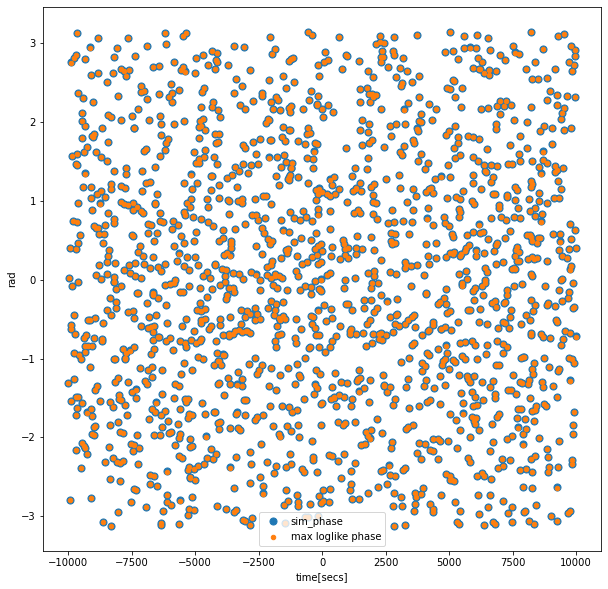

In [7]:
plt.figure(figsize=(10,10))
#plt.subplot(2,2,1)
#plt.xlim([-5000,-3000])
#plt.plot(t[:200000], np.mod((theo_phase[:200000]+ np.pi),2*np.pi) - np.pi, color = 'g',label='theo phase curve')
plt.scatter(task4.timestamp[:],np.mod((task4.phase[:]+ np.pi),2*np.pi) - np.pi,s=50, label = 'sim_phase')
plt.scatter(task4.timestamp[:], np.mod((L.get_phase()[:]+ np.pi),2*np.pi) - np.pi, s= 20,label = 'max loglike phase')
plt.xlabel('time[secs]');plt.ylabel('rad')
#plt.xlim([19.0,20])
plt.legend()

In [8]:
MCMCAnalyzer.MCMCAnalyzer(L,"/home/Zhi/QA-sim/MCMC_output/BSC_200m_T_T_5x_2",temp=2, nsamp=300000)

Bounds: [ 3.93621089e-02  3.76095653e-05 -6.30282786e-05 -1.66349541e+00] [ 5.39362109e-01  3.76145653e-05 -6.30232786e-05  2.26349541e+00]
Starting chain...
Accepted samples 1000 1
Accepted samples 2000 1
Accepted samples 3000 1
Accepted samples 4000 4
Accepted samples 5000 2
Re-initializing covariance matrix after burn-in
[[ 1.63057952e-03 -1.64747479e-11  2.64897238e-12  1.87365225e-02]
 [-1.64747479e-11  8.02099256e-19 -4.58419360e-20 -8.79851849e-10]
 [ 2.64897238e-12 -4.58419360e-20  1.19280272e-19  5.37415856e-11]
 [ 1.87365225e-02 -8.79851849e-10  5.37415856e-11  9.94028973e-01]]
V 0.3285636937539816 0.040380434925858424
d_ew 3.761179268052288e-05 8.955999417203537e-10
d_ns -6.302572815740124e-05 3.453697605621534e-10
offset 0.7152443382604304 0.9970100163670055
New maxloglike 32.38466557374208
New maxloglike 32.81947991506039
New maxloglike 32.94237744962368
New maxloglike 32.94640392320909
New maxloglike 33.11746495465361
New maxloglike 33.30037580301763
New maxloglike 33.378

Accepted samples 276000 1
Accepted samples 277000 1
Accepted samples 278000 1
Accepted samples 279000 3
Accepted samples 280000 1
Accepted samples 281000 3
Accepted samples 282000 7
Accepted samples 283000 1
Accepted samples 284000 1
Accepted samples 285000 4
Accepted samples 286000 2
Accepted samples 287000 4
Accepted samples 288000 4
Accepted samples 289000 2
Accepted samples 290000 2
Accepted samples 291000 2
Accepted samples 292000 2
Accepted samples 293000 5
Accepted samples 294000 6
Accepted samples 295000 1
Accepted samples 296000 4
Accepted samples 297000 1
Accepted samples 298000 1
Accepted samples 299000 4
Accepted samples 300000 1


590004
Sigma from MCMC = [3.61020615e-02 1.36506272e-09 6.15477062e-10 1.65943249e+00]
Sigma ew from general formula = 2.630107050201093e-10
Sigma ns from general formula = 4.407217281692399e-10


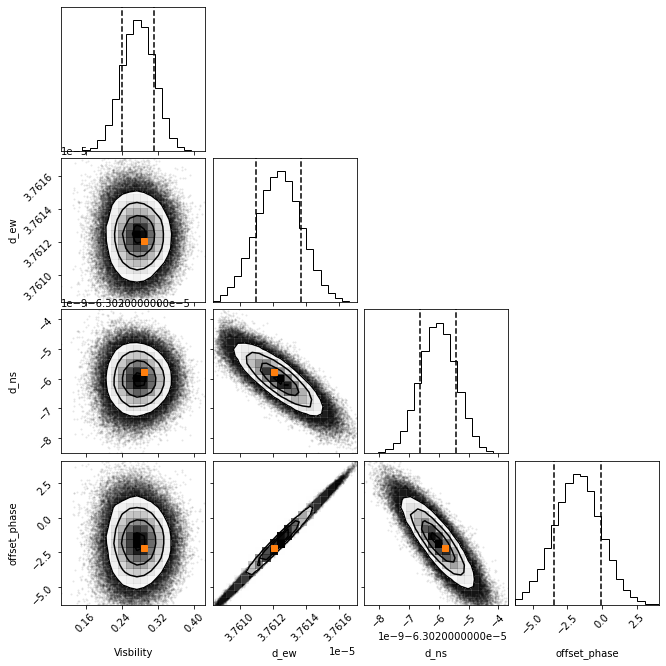

In [10]:
res = np.loadtxt("/home/Zhi/QA-sim/MCMC_output/EW_200m_2PI_T_T_10x.txt")
mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_ew','d_ns','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, np.array(theo_par)[None], marker="s", color="C1",label="Theo")

# Find sigma from the MCMC by calculating the square root of covariance matrix
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma from MCMC =",sigma)

# Find Sigma using formula in the paper:
k = (1-np.sqrt(1-task4.V**2))/task4.V**2
theo_d = np.linalg.norm(d_source[0,int(d_source[0,:,0].size/2),:])

# Using the General formula:
theo_sigma_ew = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[1]/task4.N)  #
theo_sigma_ns = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[2]/task4.N) 
print("Sigma ew from general formula =", theo_sigma_ew)
print("Sigma ns from general formula =", theo_sigma_ns)

# Using formula specfically for E-W baseline and source only ew:
#theo_sigma_ew = np.sqrt(6/(np.pi**2*k))/task4.V*lam/baseline \
#                /(T*QT.Omega_E*np.sin(?))/np.sqrt(task4.avg_rate*10*T)

590004
Sigma from MCMC = [3.53751910e-02 5.45614456e-10 2.64929924e-09 5.93677200e-01]
Sigma ew from general formula = 5.496904738877732e-10
Sigma ns from general formula = 0.0


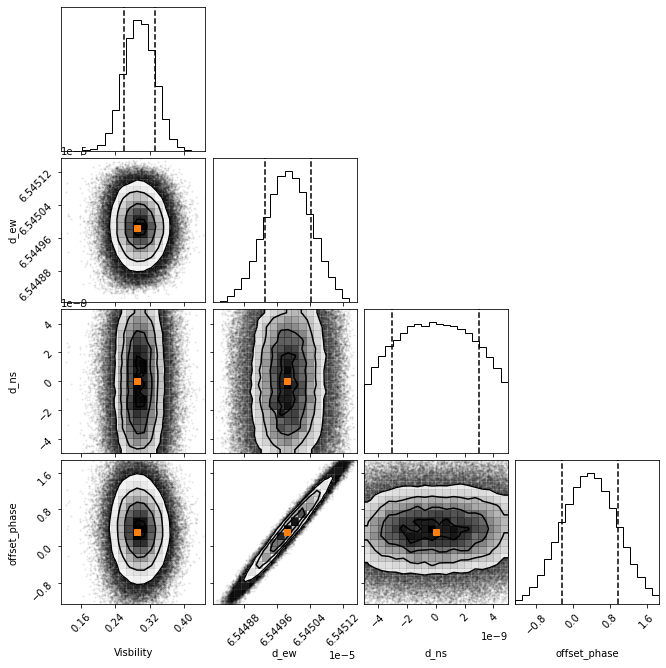

In [5]:
res = np.loadtxt("/home/Zhi/QA-sim/MCMC_output/paper_200m_T_T_10x.txt")
mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_ew','d_ns','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, np.array(theo_par)[None], marker="s", color="C1",label="Theo")

# Find sigma from the MCMC by calculating the square root of covariance matrix
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma from MCMC =",sigma)

# Find Sigma using formula in the paper:
k = (1-np.sqrt(1-task4.V**2))/task4.V**2
theo_d = np.linalg.norm(d_source[0,0,:])

# Using the General formula:
theo_sigma_ew = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[1]/task4.N)  #
theo_sigma_ns = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[2]/task4.N) 
print("Sigma ew from general formula =", theo_sigma_ew)
print("Sigma ns from general formula =", theo_sigma_ns)

590004
Sigma from MCMC = [5.05197561e-02 6.85604152e-10 5.52378908e-10 8.23568967e-01]
Sigma ew from general formula = 3.7199225000101823e-10
Sigma ns from general formula = 6.233399027369542e-10


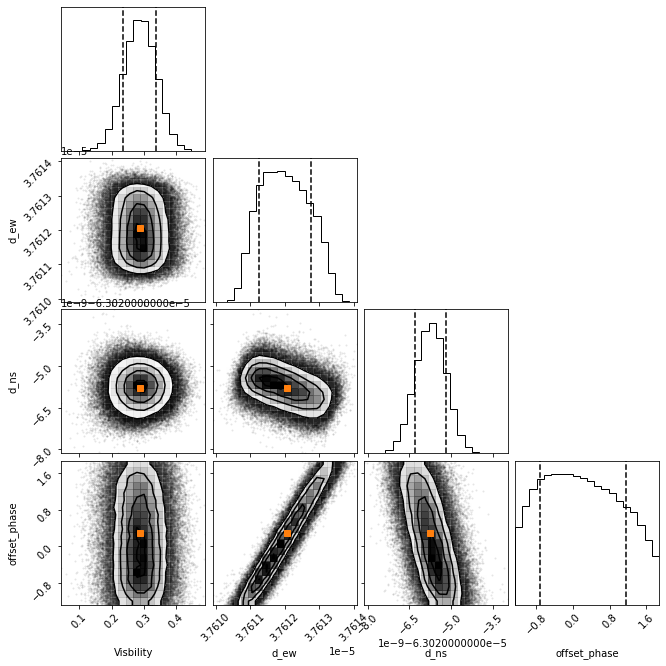

In [11]:
res = np.loadtxt("/home/Zhi/QA-sim/MCMC_output/BSC_200m_T_T_5x.txt")
mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_ew','d_ns','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, np.array(theo_par)[None], marker="s", color="C1",label="Theo")

# Find sigma from the MCMC by calculating the square root of covariance matrix
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma from MCMC =",sigma)

# Find Sigma using formula in the paper:
k = (1-np.sqrt(1-task4.V**2))/task4.V**2
theo_d = np.linalg.norm(d_source[0,0,:])

# Using the General formula:
theo_sigma_ew = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[1]/task4.N)  #
theo_sigma_ns = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[2]/task4.N) 
print("Sigma ew from general formula =", theo_sigma_ew)
print("Sigma ns from general formula =", theo_sigma_ns)


590004
Sigma from MCMC = [4.94294444e-02 8.83603613e-10 4.53340402e-10 1.00139367e+00]
Sigma ew from general formula = 2.5844896842325115e-10
Sigma ns from general formula = 4.3307771957813716e-10


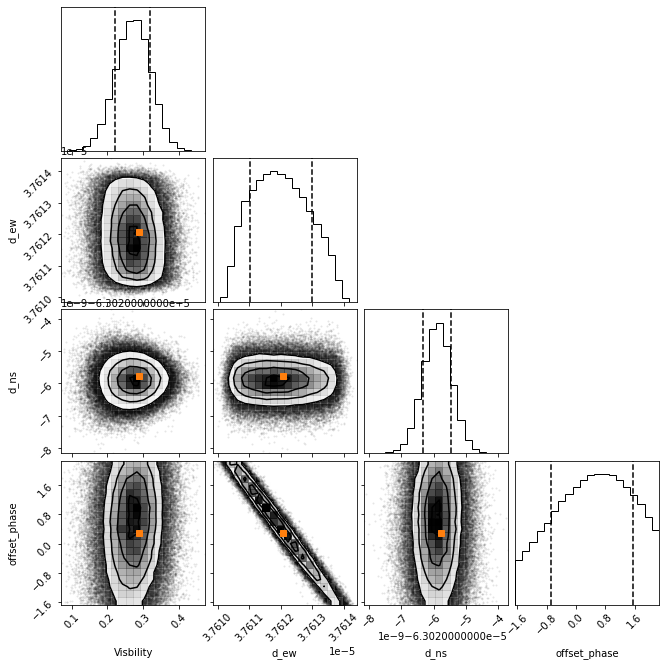

In [9]:
res = np.loadtxt("/home/Zhi/QA-sim/MCMC_output/BSC_200m_T_T_5x_2.txt")
mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_ew','d_ns','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, np.array(theo_par)[None], marker="s", color="C1",label="Theo")

# Find sigma from the MCMC by calculating the square root of covariance matrix
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma from MCMC =",sigma)

# Find Sigma using formula in the paper:
k = (1-np.sqrt(1-task4.V**2))/task4.V**2
theo_d = np.linalg.norm(d_source[0,0,:])

# Using the General formula:
theo_sigma_ew = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[1]/task4.N)  #
theo_sigma_ns = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[2]/task4.N) 
print("Sigma ew from general formula =", theo_sigma_ew)
print("Sigma ns from general formula =", theo_sigma_ns)


590004
Sigma from MCMC = [6.49668733e-02 7.08192003e-10 6.83804127e-10 8.21600779e-01]
Sigma ew from general formula = 4.802399297240566e-10
Sigma ns from general formula = 8.04728354108925e-10


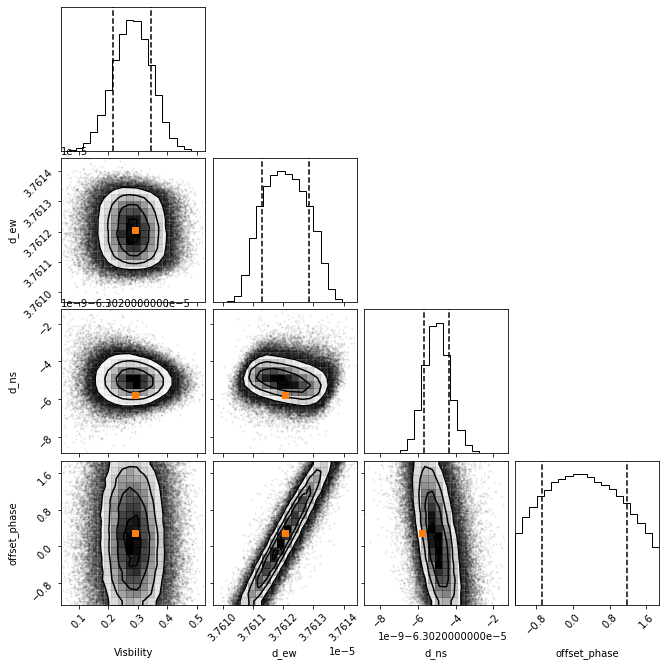

In [8]:
res = np.loadtxt("/home/Zhi/QA-sim/MCMC_output/BSC_200m_T_T_3x.txt")
mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_ew','d_ns','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, np.array(theo_par)[None], marker="s", color="C1",label="Theo")

# Find sigma from the MCMC by calculating the square root of covariance matrix
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma from MCMC =",sigma)

# Find Sigma using formula in the paper:
k = (1-np.sqrt(1-task4.V**2))/task4.V**2
theo_d = np.linalg.norm(d_source[0,0,:])

# Using the General formula:
theo_sigma_ew = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[1]/task4.N)  #
theo_sigma_ns = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[2]/task4.N) 
print("Sigma ew from general formula =", theo_sigma_ew)
print("Sigma ns from general formula =", theo_sigma_ns)


590004
Sigma from MCMC = [1.02596472e-01 9.73877800e-10 9.98265726e-10 1.02934330e+00]
Sigma ew from general formula = 8.31799958105373e-10
Sigma ns from general formula = 1.393830395607937e-09


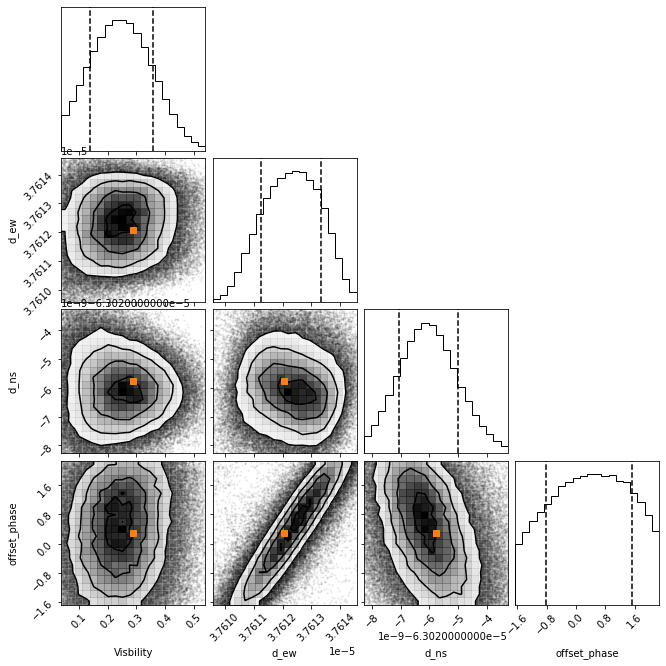

In [9]:
res = np.loadtxt("/home/Zhi/QA-sim/MCMC_output/BSC_200m_T_T_1x.txt")
mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_ew','d_ns','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, np.array(theo_par)[None], marker="s", color="C1",label="Theo")

# Find sigma from the MCMC by calculating the square root of covariance matrix
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma from MCMC =",sigma)

# Find Sigma using formula in the paper:
k = (1-np.sqrt(1-task4.V**2))/task4.V**2
theo_d = np.linalg.norm(d_source[0,0,:])

# Using the General formula:
theo_sigma_ew = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[1]/task4.N)  #
theo_sigma_ns = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[2]/task4.N) 
print("Sigma ew from general formula =", theo_sigma_ew)
print("Sigma ns from general formula =", theo_sigma_ns)

590004
Sigma from MCMC = [1.02679820e-01 9.39215170e-10 8.48713067e-10 1.02617574e+00]
Sigma ew from general formula = 8.31799958105373e-10
Sigma ns from general formula = 1.393830395607937e-09


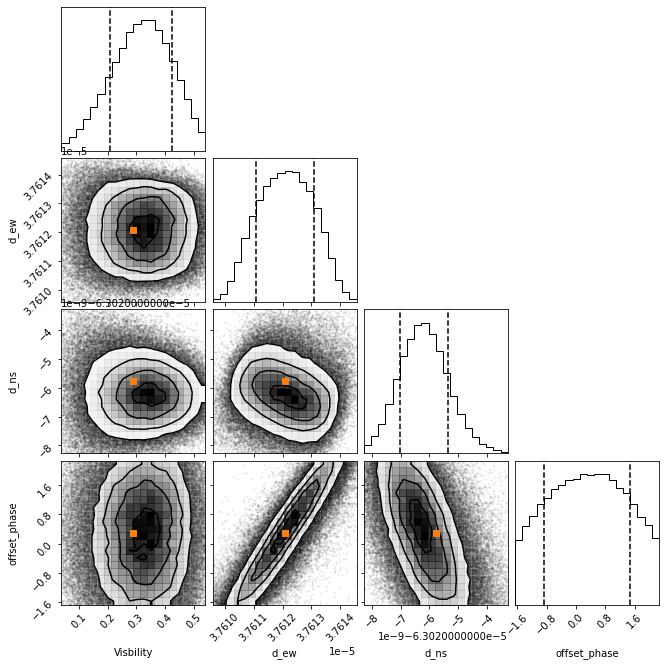

In [21]:
res = np.loadtxt("/home/Zhi/QA-sim/MCMC_output/BSC_200m_T_T_1x_2.txt")
mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_ew','d_ns','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, np.array(theo_par)[None], marker="s", color="C1",label="Theo")

# Find sigma from the MCMC by calculating the square root of covariance matrix
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma from MCMC =",sigma)

# Find Sigma using formula in the paper:
k = (1-np.sqrt(1-task4.V**2))/task4.V**2
theo_d = np.linalg.norm(d_source[0,0,:])

# Using the General formula:
theo_sigma_ew = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[1]/task4.N)  #
theo_sigma_ns = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[2]/task4.N) 
print("Sigma ew from general formula =", theo_sigma_ew)
print("Sigma ns from general formula =", theo_sigma_ns)

590004
Sigma from MCMC = [1.07061142e-01 1.00505001e-09 9.94673007e-10 1.04406727e+00]
Sigma ew from general formula = 5.779094621090863e-10
Sigma ns from general formula = 9.683912205173062e-10


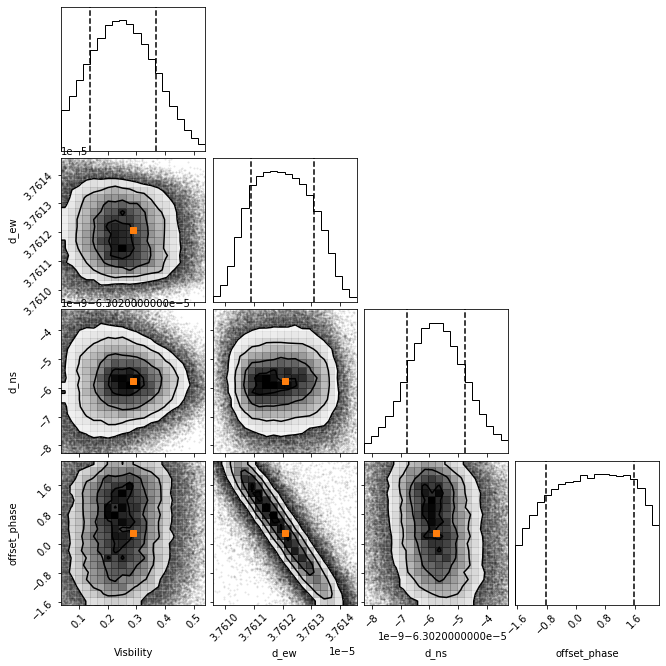

In [24]:
res = np.loadtxt("/home/Zhi/QA-sim/MCMC_output/BSC_200m_T_T_1x_3.txt")
mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_ew','d_ns','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, np.array(theo_par)[None], marker="s", color="C1",label="Theo")

# Find sigma from the MCMC by calculating the square root of covariance matrix
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma from MCMC =",sigma)

# Find Sigma using formula in the paper:
k = (1-np.sqrt(1-task4.V**2))/task4.V**2
theo_d = np.linalg.norm(d_source[0,0,:])

# Using the General formula:
theo_sigma_ew = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[1]/task4.N)  #
theo_sigma_ns = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[2]/task4.N) 
print("Sigma ew from general formula =", theo_sigma_ew)
print("Sigma ns from general formula =", theo_sigma_ns)

590004
Sigma from MCMC = [1.05504218e-01 9.81827530e-10 8.29424828e-10 1.03054377e+00]
Sigma ew from general formula = 5.779094621090863e-10
Sigma ns from general formula = 9.683912205173062e-10


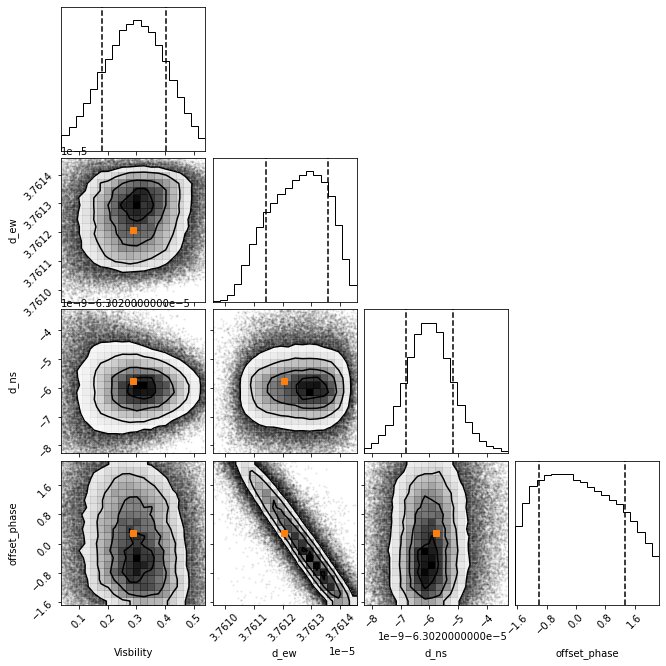

In [10]:
res = np.loadtxt("/home/Zhi/QA-sim/MCMC_output/BSC_200m_T_T_1x_4.txt")
mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_ew','d_ns','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, np.array(theo_par)[None], marker="s", color="C1",label="Theo")

# Find sigma from the MCMC by calculating the square root of covariance matrix
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma from MCMC =",sigma)

# Find Sigma using formula in the paper:
k = (1-np.sqrt(1-task4.V**2))/task4.V**2
theo_d = np.linalg.norm(d_source[0,0,:])

# Using the General formula:
theo_sigma_ew = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[1]/task4.N)  #
theo_sigma_ns = np.absolute(np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(2*T[1]*task4.avg_rate)*theo_par[2]/task4.N) 
print("Sigma ew from general formula =", theo_sigma_ew)
print("Sigma ns from general formula =", theo_sigma_ns)

In [ ]:
''' Make histogram  '''
theo_phase = task4.phase                          # Theoretical phase
theo = sim_data(theo_par,B,pos[3],task4.timestamp,lam,d_source[0,0,:])  
theo_log = theo.loglike_wprior(Num = True)

maxLike_par = np.delete(np.loadtxt("/home/Zhi/QA-sim/MCMC_output/EW_200m_6PI_T_T_10x.maxlike"),[0,1])
maxLike =sim_data(maxLike_par,B,pos[3],task4.timestamp,lam,d_source[0,0,:])  
maxLike_phase = np.mod((maxLike.get_phase() + np.pi),2*np.pi) - np.pi                  #Phase of maxlike phase
maxLike_log = maxLike.loglike_wprior(Num = True)


shift = np.array([0.,0.,0.,2.])
shiftLike = sim_data(maxLike_par+shift,B,pos[3],task4.timestamp,lam,d_source[0,0,:])
shiftLike_phase = np.mod((shiftLike.get_phase() + np.pi),2*np.pi) - np.pi    #
shiftLike_log = shiftLike.loglike_wprior(Num = True)


diff_maxLike = np.mod((maxLike_phase - theo_phase+ np.pi),2*np.pi) - np.pi     #[-pi, pi] x-axis of hist
#diff_maxLike = maxLike_phase - theo_phase

diff_shiftLike = np.mod((shiftLike_phase - theo_phase + np.pi), 2*np.pi) - np.pi  # x-axis of his
#diff_shiftLike = shiftLike_phase - theo_phase

In [ ]:
nbin = 200
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(221)
ax1.hist(diff_maxLike,nbin)
ax1.set_xlabel(r'$\Delta \phi$')
ax1.set_title('Phase diff between theo phase and maxlike phase')

ax2 = fig.add_subplot(222)
ax2.hist(diff_shiftLike,nbin)
ax2.set_xlabel(r'$\Delta \phi$')
ax2.set_title('Phase diff between Shift Phase par from maxlike and theo phase')

total loglike of diff maxlike:  887.5043852854844
total loglike of diff shiftlike:  -452.7671523958803


Text(0.5, 1.0, 'Phase diff between Shift Phase par from maxlike and theo phase')

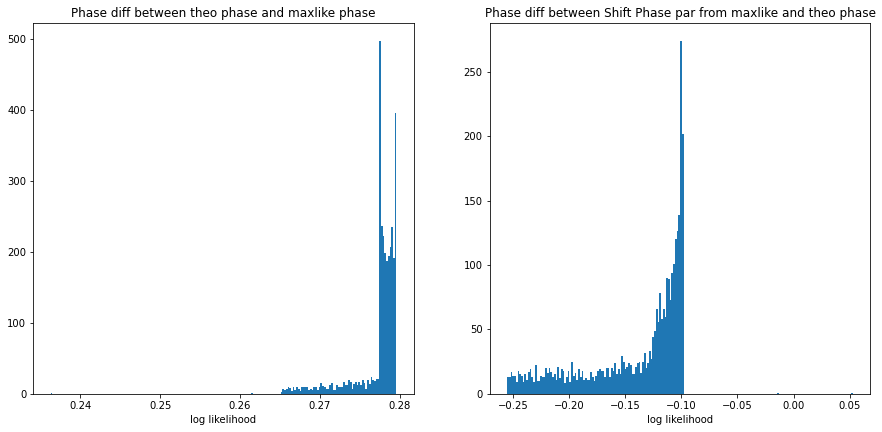

In [100]:
nbin = 200
fig = plt.figure(figsize=(15,15))
h_max = np.histogram(maxLike_log,nbin)[0]
h_shift = np.histogram(shiftLike_log,nbin)[0]

def loglike(dphi,V):
    return np.log(1+V*np.cos(dphi))

ax1 = fig.add_subplot(221)
#ax1.plot(np.linspace(np.amin(diff_maxLike),np.amax(diff_maxLike),len(h_max)),h_max)
#ax1.hist(maxLike_log,nbin)
ax1.hist(loglike(diff_maxLike,maxLike_par[0]),nbin)
print('total loglike of diff maxlike: ',np.sum(loglike(diff_maxLike,maxLike_par[0])))
ax1.set_xlabel('log likelihood');ax1.set_ylabel('')
ax1.set_title('Phase diff between theo phase and maxlike phase')

ax2 = fig.add_subplot(222)
#ax2.plot(np.linspace(np.amin(diff_shiftLike),np.amax(diff_shiftLike),len(h_shift)),h_shift)
#ax2.hist(shiftLike_log,nbin)
ax2.hist(loglike(diff_shiftLike,maxLike_par[0]),nbin)
print('total loglike of diff shiftlike: ' ,np.sum(loglike(diff_shiftLike,maxLike_par[0])))
ax2.set_xlabel('log likelihood')
ax2.set_title('Phase diff between Shift Phase par from maxlike and theo phase')

loglike after shifting phase =  33.11975190602791
loglike after shifting EW separation =  27.87493060629304


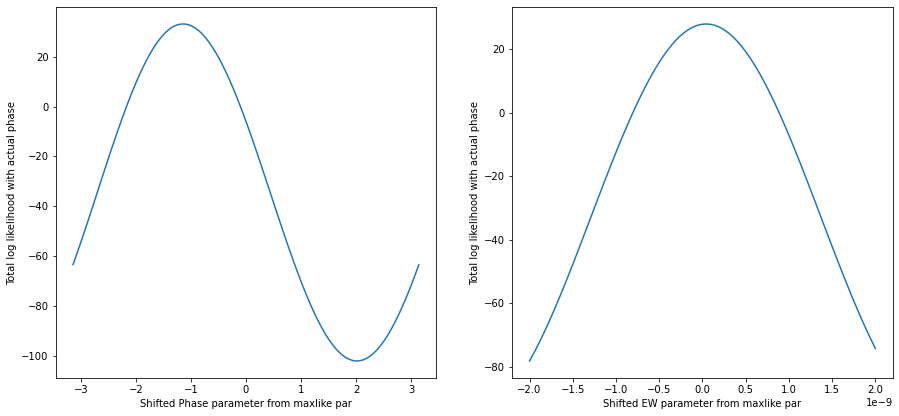

In [44]:
# For phase (not diff phase)
theo_phase = task4.phase                          # Theoretical phase
theo = sim_data(theo_par,B,source,task4.timestamp,lam,d_source[0,0,:])  

maxLike_par = np.delete(np.loadtxt("/home/Zhi/QA-sim/MCMC_output/BSC_200m_T_T_5x_2.maxlike"),[0,1])
maxLike =sim_data(maxLike_par,B,source,task4.timestamp,lam,d_source[0,0,:])  
maxLike_phase = np.mod((maxLike.get_phase() + np.pi),2*np.pi) - np.pi                  #Phase of maxlike phase

shiftLike_phi = []
phi = np.linspace(-np.pi,np.pi,100)
nbin = 200

for i in phi:
    shift = np.array([0.,1e-9,0.,i])
    shiftLike = sim_data(maxLike_par+shift,B,source,task4.timestamp,lam,d_source[0,0,:])
    shiftLike_log = shiftLike.loglike_wprior()
    shiftLike_phi.append(shiftLike_log)

shiftLike_phi = np.array(shiftLike_phi)

shiftLike_EW = []
EW = np.linspace(-2e-9,2e-9,100)
for i in EW:
    shift = np.array([0.,i,1e-9,0.])
    shiftLike = sim_data(maxLike_par+shift,B,source,task4.timestamp,lam,d_source[0,0,:])
    shiftLike_log = shiftLike.loglike_wprior()
    shiftLike_EW.append(shiftLike_log)

shiftLike_EW = np.array(shiftLike_EW)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax1.plot(phi,shiftLike_phi)
ax1.set_xlabel('Shifted Phase parameter from maxlike par');ax1.set_ylabel('Total log likelihood with actual phase')
ax2 = fig.add_subplot(222)
ax2.plot(EW,shiftLike_EW)
ax2.set_xlabel('Shifted EW parameter from maxlike par');ax2.set_ylabel('Total log likelihood with actual phase')

'''
def loglike(dphi,V):
    return np.sum(np.log(1+V*np.cos(dphi)))

shiftLike_diffPhi = []
for i in phi:
    shift = np.array([0.,2e-9,2e-9,i])
    shiftLike = sim_data(maxLike_par+shift,B,pos[3],task4.timestamp,lam,d_source[0,0,:])
    shiftLike_phase = np.mod((shiftLike.get_phase() + np.pi),2*np.pi) - np.pi    #
    diff_shiftLike = np.mod((shiftLike_phase - theo_phase + np.pi), 2*np.pi) - np.pi
    shiftLike_diffPhi.append(loglike(diff_shiftLike,maxLike_par[0]))
    
shiftLike_diffPhi = np.array(shiftLike_diffPhi)

ax2 = fig.add_subplot(222)
ax2.plot(phi,shiftLike_diffPhi)
ax2.set_xlabel('Shifted Phase parameter from maxlike par');ax1.set_ylabel('Total log likelihood with difference in phase')
'''

print('loglike after shifting phase = ',np.amax(shiftLike_phi))
print('loglike after shifting EW separation = ',np.amax(shiftLike_EW))